## Auto-correlation of volatility

In this workbook, we look at the auto-correlation between returns and volatility and see whether it could be used to add some predictive edge.

Auto-correlation is the correlation of a series with itself over a specified time lag. 

A simple definition could be found [here](https://www.investopedia.com/terms/a/autocorrelation.asp)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


In [2]:
df = pd.read_csv('/home/pi/data/sp500.csv', parse_dates=['Date']).rename(
columns = lambda x:x.lower()).sort_values(by='date').set_index('date')
df['ret'] = df.close.pct_change()
df.tail()

,open,high,low,close,volume,adj close,ret
date,,,,,,,
2021-11-24,4675.779785,4702.870117,4659.890137,4701.459961,2464040000,4701.459961,0.002294
2021-11-26,4664.629883,4664.629883,4585.430176,4594.620117,2676740000,4594.620117,-0.022725
2021-11-29,4628.750000,4672.950195,4625.259766,4655.270020,3471380000,4655.270020,0.013200
2021-11-30,4640.250000,4646.020020,4560.000000,4567.000000,4950190000,4567.000000,-0.018961
2021-12-01,4602.819824,4652.939941,4510.270020,4513.040039,4078260000,4513.040039,-0.011815


Let us calculate the monthly returns and the volatility.

 * For volatility, I would be calculating a simple standard deviation of the daily returns 
 * I would be using the close price instead of the adjusted close price. (Use adjusted close for stocks since they are prone to splits and other corporate actions that has a big impact on price)
<!-- TEASER_END -->

In [3]:
monthly_returns = df.resample('M').close.ohlc().close.pct_change()
monthly_volatility = df.resample('M').ret.std()

<AxesSubplot:title={'center':'Monthly volatility (in %)'}, xlabel='date'>

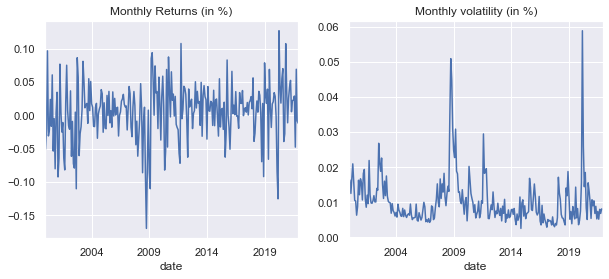

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

monthly_returns.plot(title='Monthly Returns (in %)', ax=axes[0])
monthly_volatility.plot(title='Monthly volatility (in %)', ax=axes[1])

So, we could see a big spike in volatility in the expected periods , the 2008 financial crisis and the 2020 covid crisis. We can also observe the big dip in returns.



In [5]:
print(f"Autocorrelation for returns = {monthly_returns.autocorr() :.4f}")
print(f"Autocorrelation for volatility = {monthly_volatility.autocorr() :.4f}")

Autocorrelation for returns = 0.0581
Autocorrelation for volatility = 0.6581


Hurrah! There is a big correlation between this month and next month's volatility.


Let us do the auto-correlation plot for different months.


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

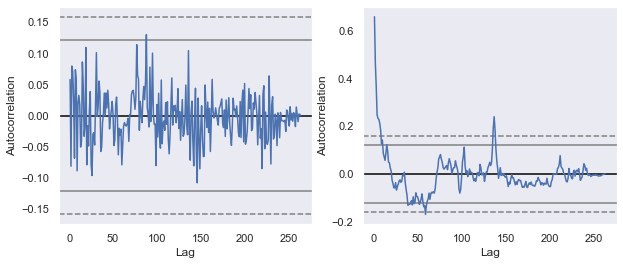

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
pd.plotting.autocorrelation_plot(monthly_returns.dropna(), ax=axes[0])
pd.plotting.autocorrelation_plot(monthly_volatility.dropna(),ax=axes[1])

In [7]:
for i in range(1,7):
    print(f"Auto-correlation for month {i} = {monthly_volatility.autocorr(lag=i) :.4f}")
    

Auto-correlation for month 1 = 0.6581
Auto-correlation for month 2 = 0.4646
Auto-correlation for month 3 = 0.3669
Auto-correlation for month 4 = 0.2495
Auto-correlation for month 5 = 0.2351
Auto-correlation for month 6 = 0.2306


From the above plots, it is clear that returns are random and previous 1 month or 2 months returns doesn't have a big impact in the forthcoming months. So, if you see some positive returns for some months, the next month may not necessarily have positive return and vice-versa; same with the second or third month. The unconditional probability of returns being positive or negative is 50% - equivalent to coin toss.

But the volatility has a good auto-correlation that extends to even 6 months, which suggests that volatility even though it shoots up suddenly has a lasting effect. The volatility of this month is going to be likely that of the previous month and there is going to be no sudden decline or increase so as to make it entirely random.

<AxesSubplot:xlabel='date'>

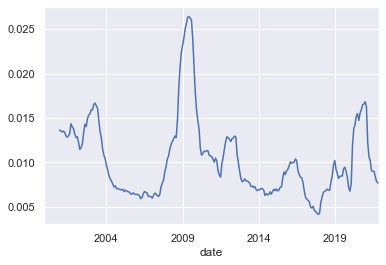

In [8]:
# Let us plot the rolling monthly volatility

monthly_volatility.rolling(12).mean().plot()

# So, the rolling volatility in 2021 is less than that of 2008

## Is there a predictive edge?

Let us try a simple filter based on volatility.

In [9]:
vol_df = pd.DataFrame({
    'returns': monthly_returns,
    'volatility': monthly_volatility
})
# I am shifting this by one row so that the previous monthly volatility is looked into
vol_df['rolling_vol'] = vol_df.volatility.rolling(12).median().shift(1)
vol_df['is_volatile'] = vol_df.eval('(volatility > rolling_vol)+0')
vol_df.groupby('is_volatile').returns.describe()

,count,mean,std,min,25%,50%,75%,max
is_volatile,,,,,,,,
0.0,152.0,0.016845,0.034129,-0.092291,0.000111,0.018150,0.035785,0.107546
1.0,112.0,-0.010584,0.049312,-0.169425,-0.034967,-0.005509,0.014216,0.126844


Looks like there is an edge to exploit that need to be investigated further.

We may try to develop a strategy based on this

Footnotes
---------
 
 * For a detailed description of autocorrelation, you could look at the [wikipedia page](https://en.wikipedia.org/wiki/Autocorrelation)
 
 * This [kaggle notebook](https://www.kaggle.com/jeegarmaru/timeseriesanalysis-autocorrelation) has a rich set of python code on this topic
 
 * Though returns don't have autocorrelation and so the probability of positive or negative returns is 50%, there is a slight edge if the probability is conditioned on some variable.